In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
# Feature Scaling
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Read the csv file
df = pd.read_csv('FinalDataForModelCreation_v4.csv')
df = df[["Departure_Date","sector_x",'Total_PAX_x','Week','# of days fly','macro_outliers', 'covid','Seasonality at week lvl', 'Seasonality at day lvl',
       'public_holiday', 'weekend', 'public_longweek/long_weekend',
       'tier1-tier1', 'tier1-tier2', 'tier2-tier1', 'tier2-tier2','Total_Pred_Search_reg_coeff','search_outlier_flag',
       'pax_outlier_flag', 'Search_MA_3', 'Search_MA_5', 'Search_MA_7',
       'Day_of_week', 'Day_of_month', 'Day_of_year', 'week_of_year',
       'WeekInMonth', 'Month_of_year', 'Quarter_of_year']]

X_train shape == (304, 14, 26).
y_train shape == (304, 1).
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.29348, saving model to weights.h5
10/10 - 7s - loss: 0.3822 - val_loss: 0.2935 - lr: 0.0200 - 7s/epoch - 714ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.29348 to 0.24064, saving model to weights.h5
10/10 - 0s - loss: 0.2842 - val_loss: 0.2406 - lr: 0.0200 - 293ms/epoch - 29ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.24064
10/10 - 0s - loss: 0.1836 - val_loss: 0.3067 - lr: 0.0200 - 266ms/epoch - 27ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.24064 to 0.23635, saving model to weights.h5
10/10 - 0s - loss: 0.1751 - val_loss: 0.2364 - lr: 0.0200 - 288ms/epoch - 29ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.23635 to 0.21234, saving model to weights.h5
10/10 - 0s - loss: 0.1545 - val_loss: 0.2123 - lr: 0.0200 - 277ms/epoch - 28ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.21234 to 0.20793, saving model to weights.h5
10/10 -

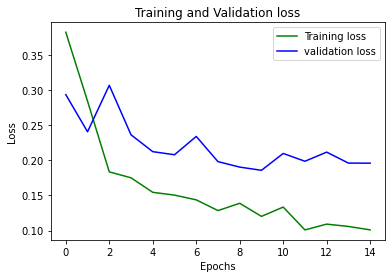

In [8]:
scope_sectors_lst = ['DEL-HYD',	'CJB-MAA',	'HYD-VTZ',	'MAA-CJB',	'DEL-GOI','MAA-HYD','DEL-BBI','BOM-HYD',
                     'HYD-DEL','HYD-BOM','DEL-PAT','DEL-RPR','DEL-BLR','BLR-BOM','BOM-GOI']

#selecting sector for model
master_df = pd.DataFrame()
future_pred_df = pd.DataFrame()


sector = 'BLR-BOM'
model_df = df[df['sector_x'] == sector]

model_df = model_df.reset_index()
model_df = model_df.drop(['index','sector_x'], axis=1)

#model_df.info()

# Importing Training Set
dataset_train = model_df.drop(['Departure_Date'], axis=1)

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[:]

# Extract dates (will be used in visualization)
datelist_train = list(model_df['Departure_Date'])
datelist_train = [dt.datetime.strptime(date, '%d-%m-%Y').date() for date in datelist_train]

# print('Training set shape == {}'.format(dataset_train.shape))
# print('All timestamps == {}'.format(len(datelist_train)))
# print('Featured selected: {}'.format(cols))

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

#print('Shape of training set == {}.'.format(training_set.shape))

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()

sc_predict.fit_transform(training_set[:, 0:1])

X_train = []
y_train = []

n_future = 47  # Number of days we want top predict into the future
n_past = 14   # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer

model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 3rd LSTM layer

model.add(LSTM(units=32, return_sequences=True))

# Adding 4th LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.50))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.02), loss='mean_squared_error')

#%%time


es = EarlyStopping(monitor='val_loss', min_delta=1e-100, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('{}_logs'.format(sector))
#folder named 'fit' would be automatically created in logs folder

history = model.fit(X_train[:-47], y_train[:-47], shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=2, batch_size=25)

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

# Perform predictions
predictions_future = model.predict(X_train[-47:])

predictions_train = model.predict(X_train[:-47])

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTION_TRAIN = pd.DataFrame(pd.date_range(start="2021-01-10",end="2022-08-15"))[0][-len(y_pred_train):]

y_pred_train_lst = y_pred_train.tolist()
resultList = []

# Traversing in till the length of the input list of lists
for m in range(len(y_pred_train_lst)):

   # using nested for loop, traversing the inner lists
   for n in range (len(y_pred_train_lst[m])):

      # Add each element to the result list
      resultList.append(y_pred_train_lst[m][n])

PREDICTION_TRAIN = pd.DataFrame(PREDICTION_TRAIN).reset_index().drop(['index'], axis=1)

PREDICTION_TRAIN = PREDICTION_TRAIN.rename(columns = {0:'dep_date'})



PREDICTION_TRAIN['predicted_pax'] = resultList

PREDICTION_TRAIN['sector'] = sector

PREDICTION_TRAIN['dep_date'] = PREDICTION_TRAIN['dep_date'].dt.strftime('%d-%m-%Y')

PREDICTION_TRAIN = pd.merge(PREDICTION_TRAIN,model_df,how="left",left_on= 'dep_date',right_on= 'Departure_Date')

PREDICTION_TRAIN = PREDICTION_TRAIN[['Departure_Date','sector','Week', '# of days fly', 'macro_outliers', 'covid',
       'Seasonality at week lvl', 'Seasonality at day lvl', 'public_holiday',
       'weekend', 'public_longweek/long_weekend', 'tier1-tier1', 'tier1-tier2',
       'tier2-tier1', 'tier2-tier2', 'Total_Pred_Search_reg_coeff',
       'search_outlier_flag', 'pax_outlier_flag', 'Search_MA_3', 'Search_MA_5',
       'Search_MA_7', 'Day_of_week', 'Day_of_month', 'Day_of_year',
       'week_of_year', 'WeekInMonth', 'Month_of_year', 'Quarter_of_year','Total_PAX_x','predicted_pax']]

y_pred_future_lst = y_pred_future.tolist()
future_resultList = []

# Traversing in till the length of the input list of lists
for m in range(len(y_pred_future_lst)):

   # using nested for loop, traversing the inner lists
   for n in range (len(y_pred_future_lst[m])):

      # Add each element to the result list
      future_resultList.append(y_pred_future_lst[m][n])

PREDICTION_TEST = pd.DataFrame(pd.date_range(start="2021-01-10",end="2022-09-30"))[0][-len(y_pred_future):]

PREDICTION_TEST = pd.DataFrame(PREDICTION_TEST).reset_index().drop(['index'], axis=1)

PREDICTION_TEST = PREDICTION_TEST.rename(columns = {0:'dep_date'})

PREDICTION_TEST['predicted_pax'] = future_resultList

PREDICTION_TEST['sector'] = sector



#plotting losses graph
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:

# create a excel writer object
with pd.ExcelWriter("{}_lstm_output_v4.xlsx".format(sector)) as writer:

    PREDICTION_TRAIN.to_excel(writer, sheet_name="master", index=False)
    PREDICTION_TEST.to_excel(writer, sheet_name="future", index=False)